In [16]:
# LT: Exclude DepDelay
# ST: Include DepDelay
# Classification: Predict if arrdelay > 0

# Import Necessary Package here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn import metrics
from sklearn import preprocessing
import gc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt

# Data Import

In [2]:
# Load CSV 
df = pd.read_csv(r"C:\Users\19665\Documents\ORIE-4741-Project\2016_to_2020_flight_feature_eng_w_Dest_10_10.csv")

In [3]:
df = df.drop('Unnamed: 0', axis = 1)
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DepDelay', 'ArrDelay', 'CRSElapsedTime',
       'Distance', 'Severe-Cold_Severity', 'Fog_Severity', 'Hail_Severity',
       'Rain_Severity', 'Snow_Severity', 'Storm_Severity',
       'Other Precipitation_Severity', 'CRSDep_afternoon', 'CRSDep_midnight',
       'CRSDep_morning', 'CRSDep_night', 'CRSArr_afternoon', 'CRSArr_midnight',
       'CRSArr_morning', 'CRSArr_night', 'Q1', 'Q2', 'Q3', 'Q4', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Airline_9E', 'Airline_AA',
       'Airline_AS', 'Airline_B6', 'Airline_DL', 'Airline_EV', 'Airline_F9',
       'Airline_G4', 'Airline_MQ', 'Airline_NK', 'Airline_OH', 'Airline_OO',
       'Airline_UA', 'Airline_VX', 'Airline_WN', 'Airline_YV', 'Airline_YX',
       'Origin_ATL', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_LAS',
       'Origin_LAX', 'Origin_MCO', 'Origin_ORD', 'Origin_PHX', 'Origin_SEA',
       'Dest_ATL', 'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_LAS', 'Dest_LAX',
       'Dest_M

In [4]:
# Check all columns are in numeric form
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

Series([], dtype: object)

In [5]:
# Check NA value 
df.isnull().values.any()

False

In [6]:
# Turn Regression into classification problem
df['is_late'] = df['ArrDelay'] > 0
df = df.drop(columns = ['ArrDelay'])

In [7]:
# Inspect all columns
pd.set_option('display.max_columns', None)
df.head() 

,Year,Month,DayofMonth,DepDelay,CRSElapsedTime,Distance,Severe-Cold_Severity,Fog_Severity,Hail_Severity,Rain_Severity,Snow_Severity,Storm_Severity,Other Precipitation_Severity,CRSDep_afternoon,CRSDep_midnight,CRSDep_morning,CRSDep_night,CRSArr_afternoon,CRSArr_midnight,CRSArr_morning,CRSArr_night,Q1,Q2,Q3,Q4,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_DL,Airline_EV,Airline_F9,Airline_G4,Airline_MQ,Airline_NK,Airline_OH,Airline_OO,Airline_UA,Airline_VX,Airline_WN,Airline_YV,Airline_YX,Origin_ATL,Origin_CLT,Origin_DEN,Origin_DFW,Origin_LAS,Origin_LAX,Origin_MCO,Origin_ORD,Origin_PHX,Origin_SEA,Dest_ATL,Dest_CLT,Dest_DEN,Dest_DFW,Dest_LAS,Dest_LAX,Dest_MCO,Dest_ORD,Dest_PHX,Dest_SEA,is_late
0,2016,1,1,0.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
1,2016,1,2,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
2,2016,1,3,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
3,2016,1,4,2.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True
4,2016,1,5,558.0,149.0,868.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True


# Long vs Short Term Model
As discussed in porposal, we will have two models, one predicting delay before passengers arrive at the airport, and the other one predict delay using all data avaliable until the plane left the ground.

Here, some columns contain data that will only be avaliable when the passengers board the plane (like DepDelay and Weather). We cannot use them in our long-run forecase, but we can include them in our short-run forecast.

In [8]:
weather_columns = ['Severe-Cold', 'Fog', 'Hail', 'Rain', 'Snow', 'Storm', 'Other Precipitation']
ST_columns = ['DepDelay'] 
df_LT = df[df.columns.difference(ST_columns)]
# df_ST = df

In [9]:
del [[df]]
gc.collect()

18

In [10]:
# Specify X and y
X = df_LT.drop(columns = ['is_late'])
y = pd.DataFrame(df_LT['is_late'])

# X = df_ST.drop(columns = ['is_late'])
# y = pd.DataFrame(df_ST['is_late'])


# Perform train-test-validation split (Train: 0.6, test: 0.2, Val: 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [11]:
X_val.shape

(393817, 68)

In [12]:
X_test.shape

(393817, 68)

In [17]:
X_test.columns

Index(['Airline_9E', 'Airline_AA', 'Airline_AS', 'Airline_B6', 'Airline_DL',
       'Airline_EV', 'Airline_F9', 'Airline_G4', 'Airline_MQ', 'Airline_NK',
       'Airline_OH', 'Airline_OO', 'Airline_UA', 'Airline_VX', 'Airline_WN',
       'Airline_YV', 'Airline_YX', 'CRSArr_afternoon', 'CRSArr_midnight',
       'CRSArr_morning', 'CRSArr_night', 'CRSDep_afternoon', 'CRSDep_midnight',
       'CRSDep_morning', 'CRSDep_night', 'CRSElapsedTime', 'DayofMonth',
       'Dest_ATL', 'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_LAS', 'Dest_LAX',
       'Dest_MCO', 'Dest_ORD', 'Dest_PHX', 'Dest_SEA', 'Distance',
       'Fog_Severity', 'Fri', 'Hail_Severity', 'Mon', 'Month', 'Origin_ATL',
       'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_LAS', 'Origin_LAX',
       'Origin_MCO', 'Origin_ORD', 'Origin_PHX', 'Origin_SEA',
       'Other Precipitation_Severity', 'Q1', 'Q2', 'Q3', 'Q4', 'Rain_Severity',
       'Sat', 'Severe-Cold_Severity', 'Snow_Severity', 'Storm_Severity', 'Sun',
       'Thu', 'Tue'

In [13]:
X_train.shape

(1181450, 68)

# Logistic regression (LT)
As a start, we will fit a simple linear regression with y = is_late. As the dataset is inbalanced, we would use the weighted avg of F-1 score as our evaluation metrics

## Balanced and Unbalanced Regression
### Balanced Fitting

In [20]:
model_balanced = 'balanced'
num_worker = 8

In [21]:
logistic = LogisticRegression(class_weight = model_balanced, n_jobs = num_worker)
logistic.fit(X_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced', n_jobs=8)

In [22]:
# See Train 
pred = logistic.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.69      0.56      0.62    747929
        True       0.43      0.57      0.49    433521

    accuracy                           0.56   1181450
   macro avg       0.56      0.56      0.55   1181450
weighted avg       0.59      0.56      0.57   1181450



In [23]:
# See Test 
pred = logistic.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.69      0.55      0.61    249535
        True       0.43      0.57      0.49    144282

    accuracy                           0.56    393817
   macro avg       0.56      0.56      0.55    393817
weighted avg       0.59      0.56      0.57    393817



### Unbalanced Fitting

In [24]:
model_balanced = None
logistic_unbalanced = LogisticRegression(class_weight = model_balanced, n_jobs = num_worker)
logistic_unbalanced.fit(X_train, y_train.values.ravel())

LogisticRegression(n_jobs=8)

In [25]:
# See Train 
pred = logistic_unbalanced.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.64      0.99      0.78    747929
        True       0.65      0.02      0.04    433521

    accuracy                           0.64   1181450
   macro avg       0.65      0.51      0.41   1181450
weighted avg       0.64      0.64      0.51   1181450



In [26]:
# See Test 
pred = logistic_unbalanced.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.64      0.99      0.78    249535
        True       0.64      0.02      0.04    144282

    accuracy                           0.64    393817
   macro avg       0.64      0.51      0.41    393817
weighted avg       0.64      0.64      0.51    393817



### Dummy Majority Classifier Result

In [28]:
# See dummy majority classfier
pred = np.zeros(y_test.values.shape[0])
print(classification_report(y_test.values.ravel(), pred))

C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.63      1.00      0.78    249535
        True       0.00      0.00      0.00    144282

    accuracy                           0.63    393817
   macro avg       0.32      0.50      0.39    393817
weighted avg       0.40      0.63      0.49    393817



C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Result

We observed that balanced training seems to be the best approach as it yields highest weighted average F-1 score, and they are both better than the dummy classifier. Since balanced model has a better accuracy, we will only run hyperparameter tuning for balanced logistic regression


## Feature Scaling and Normalization
Although most of our data features are one-hot generated, features like year and distance are order-of-magitude different from 1 and 0. We would like to see if normalizing all features to the same scale could help mitigate this disrepency

In [14]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
# Use same scaler obtained from training sample because test data are supposed to be completely unknown
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [16]:
model_balanced = 'balanced'
num_worker = 8
logistic_scaled = LogisticRegression(class_weight = model_balanced, n_jobs = num_worker)
logistic_scaled.fit(X_train_scaled, y_train.values.ravel())

LogisticRegression(class_weight='balanced', n_jobs=8)

In [33]:
# See Train 
pred = logistic_scaled.predict(X_train_scaled)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.71      0.60      0.65    747929
        True       0.45      0.57      0.51    433521

    accuracy                           0.59   1181450
   macro avg       0.58      0.59      0.58   1181450
weighted avg       0.61      0.59      0.60   1181450



In [34]:
# See Test 
pred = logistic_scaled.predict(X_test_scaled)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.71      0.60      0.65    249535
        True       0.45      0.57      0.50    144282

    accuracy                           0.59    393817
   macro avg       0.58      0.58      0.57    393817
weighted avg       0.61      0.59      0.59    393817



### Conclusion
We are able to confirm that a standard normalization proedure helped with increasing F-1 score by around 3.5%

## Hyperparameter Tuning
Logistic regression comes with various hyperparameters, including penalty and regularization constant. We will try to find the best parameter set for balanced, normalized, logistic regression.

In [17]:
parameters =  [{'penalty': ['l1','l2'], 'C': [0.001,1,1000]},{'penalty': ['none']}]
clf = GridSearchCV(LogisticRegression(class_weight = 'balanced', solver = 'saga'), parameters, scoring='f1_weighted', n_jobs = 7, verbose = 3, cv = 3)
clf.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


C:\Users\19665\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='saga'),
             n_jobs=7,
             param_grid=[{'C': [0.001, 1, 1000], 'penalty': ['l1', 'l2']},
                         {'penalty': ['none']}],
             scoring='f1_weighted', verbose=3)

In [22]:
print(clf.cv_results_)

{'mean_fit_time': array([ 95.49118074,  71.22671445, 104.74960097,  91.13920108,
       107.59190822,  91.03184287,  87.33767724]), 'std_fit_time': array([0.92587759, 0.28996737, 1.59765347, 0.38774472, 0.08458165,
       0.06308214, 2.24153028]), 'mean_score_time': array([0.18770933, 0.18904265, 0.18737531, 0.18104116, 0.17170525,
       0.16537102, 0.14769991]), 'std_score_time': array([0.00694538, 0.01855122, 0.00801599, 0.00707314, 0.00471539,
       0.00612995, 0.00249487]), 'param_C': masked_array(data=[0.001, 0.001, 1, 1, 1000, 1000, --],
             mask=[False, False, False, False, False, False,  True],
       fill_value='?',
            dtype=object), 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'none'],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.001, 'penalty': 'l1'}, {'C': 0.001, 'penalty': 'l2'}, {'C': 1, 'penalty': 'l1'}, {'C': 1, 'penalty': 'l2'}, {'

### Result
As a result, we observed that having c= 1 and no penalty are similiar and thus having no regularizing term is probably the best as Logistic regression is actually underfitting

## Final Model
Our final logistic regression is trained with:
1. balanced data
2. normalized features
3. no regularization penaties


In [15]:
logistic_final = LogisticRegression(class_weight = 'balanced', n_jobs = 8, penalty = 'none',solver = 'saga')
logistic_final.fit(X_train_scaled, y_train.values.ravel())


LogisticRegression(class_weight='balanced', n_jobs=8, penalty='none',
                   solver='saga')

In [18]:
# See Train 
pred = logistic_final.predict(X_train_scaled)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.71      0.60      0.65    748341
        True       0.45      0.57      0.50    433109

    accuracy                           0.59   1181450
   macro avg       0.58      0.58      0.58   1181450
weighted avg       0.61      0.59      0.59   1181450



In [19]:
# See Test 
pred = logistic_final.predict(X_test_scaled)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.71      0.60      0.65    249259
        True       0.45      0.57      0.51    144558

    accuracy                           0.59    393817
   macro avg       0.58      0.58      0.58    393817
weighted avg       0.61      0.59      0.59    393817



## Fairness (for each airline)
We can determine this  by comparing the weighted F-1 score for each of them

In [25]:
result = []
names = []
for col_name in X_test.columns:
    if 'Airline_' in col_name:
        X_sub = scaler.transform(X_test.loc[X_test[col_name] == 1])
        y_sub = y_test.loc[X_test[col_name] == 1]
        pred = logistic_final.predict(X_sub)
        names.append(col_name)
        result.append(f1_score(y_sub.values.ravel(), pred, average='weighted'))

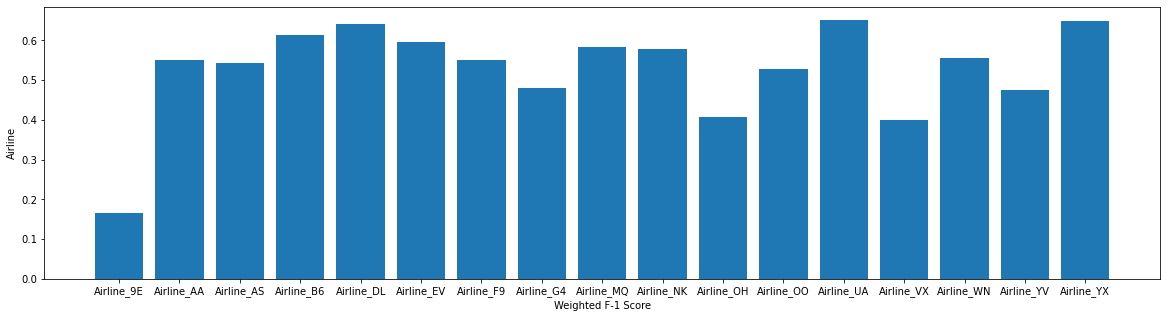

In [30]:
plt.rcParams["figure.figsize"] = (20,5)
plt.bar(names,result)
plt.xlabel('Weighted F-1 Score')
plt.ylabel('Airline')
plt.show()